#P3 Wrangle OSM Data with MongoDB - Paris Metroline

**Map area : Paris Metroline, France**

Source : https://mapzen.com/data/metro-extracts/

To the outside world, working as a Data Scientist is often associated with Machine Learning, cool visualization and statistics. But an important part of the Data Scientist job is also to prepare data (i.e. gathering it, cleaning it, and storing it in a convenient format) before applying all the analytical tools available. 

The goal of this work is to use data from the Open Street Map community to learn how to assess data quality, clean data if need be, and store it in a MongoDB database. The major skill I want to hone and apply here are:
- Assessing the quality of the data for validity, accuracy, completeness, consistency and uniformity
- Parsing and gathering data from popular file formats such as .json and .xml
- Process data from very large files that can not be cleaned with spreadsheet programs
- Learn how to store, query, and aggregate data using MongoDB

The first part of my work is focused on getting some first clues about data quality of the OSM file. The idea is to find out which treatment has to be done to the data before importing it to the database. 

But as the file size is very big, it is not very handy to do all the auditing via the OSM file. This is why, after having imported the data into MongoDB, I start with some further auditing in order to check the data quality level. 

When satisfied with the MongoDB database, I use some queries to analyze the OSM data further and try to find out interesting numbers or trends with the Paris Metroline data.


##I need a smaller file to play with...

In order to run my first scripts, test them, and debug them, I need to use a smaller file than the entire Paris OSM data (4.4GB). The following code simply produces a file based on the original OSM data but limited to the first 100 000 lines.

The final version of the work is done on the entire dataset. 

In [12]:
import codecs

lines = 100000 # maximum number of lines to be copied in the smaller file
file_in = 'data\\paris_france.osm'
file_out = '{0}_extract.{1}'.format(file_in.split('.')[0], file_in.split('.')[1])

def small_file(file_in, file_out, lines):
    i = 0
    with codecs.open(file_out, 'w') as fo:
        with codecs.open(file_in, 'r') as fi:
            for line in fi:
                if i < lines:
                    i += 1
                    fo.write(line)
                elif i == lines:
                    fo.write('</osm>')    # Adding osm end tag in the end of the file to close the osm tag from the file start
                    i += 1
                else:
                    break

#small_file(file_in, file_out, lines)

##Some first look at the data...

###What are the main kind of element in the data?

The following code finds out what types of element are there, but also how many, to get the feeling of how much of each type of data I can expect to find in the OSM map.

In [2]:
import xml.etree.cElementTree as ET
import pprint

def count_tags(filename):
    tags = {}
    for event, elem in ET.iterparse(filename):
        if elem.tag in tags:
            tags[elem.tag] += 1
        else:
            tags[elem.tag] = 1
        elem.clear()
    return tags

tags = count_tags('data\\paris_france_extract.osm')
pprint.pprint(tags)
 

{'bounds': 1,
 'member': 485026,
 'nd': 24986099,
 'node': 18588534,
 'osm': 1,
 'relation': 35382,
 'tag': 9670757,
 'way': 3059389}


This is consistant with the OSM standard schema. For the MongoDB database, we will not import the 'bounds' and 'osm' elements.

###What is the quality of the 'k' entries from the tag value?
The following code reuses some work from the problem sets, and checks the "k" value for each "<tag>" in order to see if they can be valid keys in MongoDB.

In [73]:
import xml.etree.cElementTree as ET
import pprint
import re

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}

for _, element in ET.iterparse('data\\paris_france_extract.osm'):
    if element.tag == "tag":
        for tag in element.iter('tag'):
            k = tag.get('k')
            if re.match(lower, k):
                keys['lower'] += 1
            elif re.match(lower_colon, k):
                keys['lower_colon'] += 1
            elif re.match(problemchars, k):
                keys['problemchars'] += 1   
            else :
                keys['other'] += 1   
    element.clear()
print keys

{'problemchars': 0, 'lower': 8545836, 'other': 255948, 'lower_colon': 868973}


We can see that there is no problematical character for these entries. 

###Auditing street names
Let's have a look at the first street names we bump into in the small dataset.

In [13]:
import xml.etree.cElementTree as ET
import pprint
import re

for _, element in ET.iterparse('data\\paris_france_extract.osm'):
    if element.tag in ['way', 'node', 'relation']: 
        for subel in element:
            if subel.get('k') == 'addr:street':
                print subel.get('v')  
        element.clear()

Quai Marcel Dassault
Boulevard Henri Barbusse
Avenue de l'Océanie
Rue Sainte-Opportune
Rue Pierre Brossolette
Rue Ledru-Rollin
Avenue Franklin Roosevelt
route de Romainville
Rue du Disque
Avenue Gabriel Péri
Rue Duhesme
Rue Mirabeau
Rue de Grenelle
Avenue de la Division Leclerc
Rue Gabriel Péri
Allée René Descartes
Rue des Plantes
Place de l'Hôtel de Ville
avenue Joliot Curie
Quai Branly
Quai Branly
Quai Branly
Quai Branly
Rue de la République
Rue Yves le Coz
Rue de Paris
Rue de la Paroisse
Rue de la Paroisse
Rue Corneille
Rue Jean Mermoz
Boulevard de Bonne Nouvelle
quai de Gesvres
Boulevard Kellermann
Grande Rue
Rue du Bas Igny
Avenue Émile Cossonneau
Rue Pablo Neruda
Avenue Pablo Picasso
Boulevard Saint-Germain


I am a bit astonished by the quality of the street name. The only uniformity issue that I found was that some street name began with a lower case, instead of an uppercase. I adapted the pre-processing code that produces the json file to be stored in the database in order to handle this correction.

Except for that, all the names were formatted in a consistent way and seemed to be legitimate, which led me to believe that there is no more uniformity or validity issue. 

###Auditing 'v' tag values
We already saw that the 'k' tags were of descent quality. The following code now focuses on the 'v' tags to spot any uniformity issue.

In [16]:
import xml.etree.cElementTree as ET
import pprint
import re

i = 0
i_max = 250

for _, element in ET.iterparse('data\\paris_france_extract.osm'):
    if element.tag in ['way', 'node', 'relation']: 
        for subel in element:
            if i < i_max:
                i += 1
                print subel.get('k'), ': ', subel.get('v') 
            else:
                element.clear()
                break
        element.clear()

exit_to :  A 104; Soissons; Marne-la-Vallée
highway :  motorway_junction
ref :  A 6
highway :  milestone
distance :  13
ref :  5
name :  Chilly-Mazarin-Morangis-Longjumeau
highway :  motorway_junction
ref :  6
name :  Savigny-sur-Orge - Épinay-sur-Orge - Morsang-sur-Orge - Sainte-Geneviève-des-Bois
highway :  motorway_junction
maxspeed :  50
traffic_sign :  maxspeed
exit_to :  A 6b; Metz; Lille; Arcueil; Périphérique Est
highway :  motorway_junction
source :  local Knowledge
highway :  traffic_signals
highway :  traffic_signals
highway :  traffic_signals
highway :  traffic_signals
highway :  traffic_signals
highway :  traffic_signals
highway :  traffic_signals
highway :  traffic_signals
highway :  traffic_signals
highway :  traffic_signals
highway :  traffic_signals
name :  Place de Barcelone
highway :  traffic_signals
junction :  yes
highway :  traffic_signals
highway :  traffic_signals
highway :  traffic_signals
bicycle :  yes
highway :  crossing
highway :  traffic_signals
foot :  ye

It is difficult to assess the uniformity level of all these different entries. The goal here is not to ensure uniformity for each entry types, but more to spot some uniformity issues that pops up frequently.

To that extent, we can see that the '\_' character is always used to separate two words. I will replace it by a whitespace in the MongoDB database.

###Auditing population values
I want to analyze the population entries in the MongoDB database. Hence, I'm checking here if the format read from the OSM file will enable me to so after importing it.

In [19]:
import xml.etree.cElementTree as ET
import pprint
import re

for _, element in ET.iterparse('data\\paris_france_extract.osm'):
    if element.tag in ['way', 'node', 'relation']: 
        for subel in element:
            if subel.get('k') == 'population':
                print subel.get('v'), type(subel.get('v'))
        element.clear()

2243833 <type 'str'>
561 <type 'str'>
114205 <type 'str'>
13693 <type 'str'>
26465 <type 'str'>
19775 <type 'str'>
17272 <type 'str'>
14250 <type 'str'>
20609 <type 'str'>
35658 <type 'str'>
28975 <type 'str'>
30173 <type 'str'>
17100 <type 'str'>
22425 <type 'str'>
30285 <type 'str'>
61793 <type 'str'>
20508 <type 'str'>
33498 <type 'str'>
15905 <type 'str'>
76087 <type 'str'>
12174 <type 'str'>
30393 <type 'str'>
33097 <type 'str'>
18000 <type 'str'>
33829 <type 'str'>
15660 <type 'str'>
58916 <type 'str'>
56988 <type 'str'>
51438 <type 'str'>
52779 <type 'str'>
19626 <type 'str'>
15418 <type 'str'>
27727 <type 'str'>
20089 <type 'str'>
35380 <type 'str'>
14560 <type 'str'>
13395 <type 'str'>
13812 <type 'str'>
14766 <type 'str'>
36842 <type 'str'>
16249 <type 'str'>
53400 <type 'str'>
15966 <type 'str'>
15625 <type 'str'>
11809 <type 'str'>
82300 <type 'str'>
89185 <type 'str'>
27966 <type 'str'>
54518 <type 'str'>
24792 <type 'str'>
20268 <type 'str'>
16251 <type 'str'>
26736 <type

The population entries seem to be uniform. But they are all read as strings. So we need to make sure to import them as integers in the data base. That way, we will have uniform and valid data for the population entries.

###Which entries should be transferred to the MongoDB database ?

I already know that I will transfer some basic entries, like information about its creation, or the geoposition data.

But I also want to have a better idea about the kind of tags that are the most frequent in my OSM data. By spotting the most frequent tag, I will be able to better focus my work on the data which is relevant.

In [3]:
import xml.etree.cElementTree as ET
import collections
import operator

tags = collections.defaultdict(int)
i = 0
nlines = 56825189    # number of lines in the osm file
line_prog = [(1 + i) * nlines / 100 for i in xrange(100)]

#Collecting and counting the tag k values
for _, element in ET.iterparse('data\\paris_france_extract.osm'):
    i+=1
    if i in line_prog:
        print '{0:0.1f} % of original file has been processed'.format(100 * float(i)/nlines)

    if element.tag == "tag":
        for tag in element.iter('tag'):            
            if tag.get('k'):
                tags[tag.get('k')] += 1
    element.clear()

#Sorting the tags in descinding order
#source : http://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value
sorted_tags = sorted(tags.items(), key=operator.itemgetter(1),reverse=True)

for i in xrange(100):
    print sorted_tags[i]

1.0 % of original file has been processed
2.0 % of original file has been processed
3.0 % of original file has been processed
4.0 % of original file has been processed
5.0 % of original file has been processed
6.0 % of original file has been processed
7.0 % of original file has been processed
8.0 % of original file has been processed
9.0 % of original file has been processed
10.0 % of original file has been processed
11.0 % of original file has been processed
12.0 % of original file has been processed
13.0 % of original file has been processed
14.0 % of original file has been processed
15.0 % of original file has been processed
16.0 % of original file has been processed
17.0 % of original file has been processed
18.0 % of original file has been processed
19.0 % of original file has been processed
20.0 % of original file has been processed
21.0 % of original file has been processed
22.0 % of original file has been processed
23.0 % of original file has been processed
24.0 % of original f

We can see that, as expected, the majority of tags is related to traffic (highway, barrier, traffic calming, STIF, RATP, etc.), location (address, place, etc.) and usage (amenity, phone, tourism, opening hour).

I used this list to select which tags I wanted to include in the MongoDB Database. The goal was to import only the most useful data in the database to limit the space needed. 

##Let's prepare our data for the MongoDB database

The following code reads the OSM file and process it line by line to create JSON structures that can be implemented in a MongoDB database. The processed data is store in a JSON file on the disk.

Only the most useful and frequent entries are kept. I found the following resource useful to understand the basic OSM data structure.

http://wiki.openstreetmap.org/wiki/OSM_XML

In [24]:
#!/usr/bin/env python
# coding: utf-8
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json

problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

# the CREATED list selects the tags related to the "created" sub-dictionnary that will be imported in the json file.
CREATED = [ 'version', 'changeset', 'timestamp', 'user', 'uid']

# the INCLUDE list selects the tags that will be imported in the json file 
INCLUDE = ['name', 'place', 'railway', 'highway', 'amenity', 
           'crossing', 'exit_to', 'public_transport', 'traffic_calming', 'bicycle', 'foot', 'power', 
           'shop', 'tourism', 'bus', 'cuisine', 'train', 'opening_hours', 'subway', 
           'source', 'building', 'wall', 'natural', 'oneway', 'taxon:species','building:levels',
           'genus', 'circumference', 'height', 'maxspeed', 'operator', 'access',
           'surface', 'barrier', 'service', 'layer', 'landuse', 'leisure', 'level', 'lanes', 'wheelchair', 
           'taxon:species:varietas', 'lit', 'sport', 'voltage', 'electrified', 'bridge', 'cycleway', 'shelter',
           'frequency', 'emergency', 'network', 'tunnel', 'capacity', 'junction', 'parking', 'area', 'seats', 'usage',
           'waterway', 'sidewalk', 'tracktype', 'tactile_paving', 'material', 'bench']

def shape_geodata(key, value, node):
    '''
    This function creates a tuple with the geographical coordonates for future indexing
    '''
    if key == 'lon':    
        try:
            node['pos'][1] = float(value)
        except KeyError:
            node['pos'] = [None, None]
            node['pos'][1] = float(value)
    if key == 'lat':    
        try:
            node['pos'][0] = float(value)
        except KeyError:
            node['pos'] = [None, None]
            node['pos'][0] = float(value)    
    return node


def shape_element(element):
    '''
    This function processes an ETREE element in order to reshape it into a json-like format. 
    It only transfers the most frequent and relevant entries spotted with the previous analysis.
    It calls the shape_geodata() function and uses the CREATED and INCLUDE global variables.
    '''
    node = {}
    node['created'] = {}
    if element.tag in ['way', 'node', 'relation']:        
        ### process for all first-level elements (way, node, relation) ###
        for key, value in element.attrib.items():
            node['type'] = element.tag    # specifies the kind of element
            if key in ['id', 'visible']: 
                node[key] = value
            if key in CREATED:    # creating a specific subsection about data when the tag was created
                node['created'][key] = value 
            if key in ['lat', 'lon']:    # creating a tuple with the geographical coordonates for future indexing
                node = shape_geodata(key, value, node)

        ## process for all sub-elements (nd, members, tag) ##
        for tag in element:
            t_key = tag.get('k')
            t_value = tag.get('v')
            # if the k value is part of the INCLUDE list, it is included in the json Data
            if t_key in INCLUDE:
                t_value = re.sub('_', ' ', t_value) # replacing '_' character by whitespace
                node[t_key] = t_value 
            # for the population entry, convert the string value into integer
            if t_key == 'population':
                node[t_key] = int(t_value)
            # if the second level tag "k" value contains problematic characters, it should be ignored
            if t_key != None and re.search(problemchars, t_key):
                pass            
            # if the second level tag "k" value starts with "addr:", it should be added to a dictionary "address"
            # if there is a second ":" that separates the type/direction of a street, the tag should be ignored
            if t_key != None and re.match("addr:", t_key):
                if re.match('addr:.+:', t_key):
                    pass                
                else:
                    if t_key == 'addr:street':
                        if t_value[0].islower():
                            t_value = t_value[0].upper() + t_value[1:] # replace first letter by uppercase
                    try:
                        node['address'][re.sub('addr:','',t_key)] = t_value   
                    except KeyError:
                        node['address'] = {}
                        node['address'][re.sub('addr:','',t_key)] = t_value 
                        
            # defining node references as a list ==> "node_refs": ["305896090", "1719825889"]
            if tag.tag == 'nd':
                t_ref = tag.get('ref')                
                try:
                    node['node_refs'].append(t_ref)
                except KeyError:
                    node['node_refs'] = []
                    node['node_refs'].append(t_ref) 
            # defining members reference as a list
            if tag.tag == 'member':
                t_ref = tag.get('ref') 
                t_type = tag.get('type')
                try:
                    node['members'].append({'type':t_type,'ref':t_ref})
                except KeyError:
                    node['members'] = []
                    node['members'].append({'type':t_type,'ref':t_ref})      
        return node
    else:
        return None    



def process_map(file_in):
    file_out = "{0}.json".format(file_in)
    
    # trick to follow the file processing
    i = 0
    nlines = 56825189    # number of lines in the osm file
    line_prog = [(1 + i) * nlines / 100 for i in xrange(100)]
    
    # file processing
    with codecs.open(file_out, "w", 'utf-8') as fo:
        for _, element in ET.iterparse(file_in):
            i += 1
            el = shape_element(element)
            if i in line_prog:
                print '{0:0.1f} % of original file has been processed'.format(100 * float(i)/nlines)
            if el:
                fo.write(json.dumps(el) + "\n")
                el.clear()
                element.clear()
            else:
                pass
            
    return None


if __name__ == "__main__":
    process_map('data\\paris_france_extract.osm')

1.0 % of original file has been processed
2.0 % of original file has been processed
3.0 % of original file has been processed
4.0 % of original file has been processed
5.0 % of original file has been processed
6.0 % of original file has been processed
7.0 % of original file has been processed
8.0 % of original file has been processed
9.0 % of original file has been processed
10.0 % of original file has been processed
11.0 % of original file has been processed
12.0 % of original file has been processed
13.0 % of original file has been processed
14.0 % of original file has been processed
15.0 % of original file has been processed
16.0 % of original file has been processed
17.0 % of original file has been processed
18.0 % of original file has been processed
19.0 % of original file has been processed
20.0 % of original file has been processed
21.0 % of original file has been processed
22.0 % of original file has been processed
23.0 % of original file has been processed
24.0 % of original f

##Import in the MongoDB database
The following code reads the JSON file line by line and import it in the MongoDB database.

In order to avoid calling the database for each line, a temporary list is created to store a number of lines representing one hundredth of the JSON file. The list is then bulk imported in the MongoDB database and cleared to get new files.

In [25]:
from pymongo import MongoClient
import codecs
import json

client = MongoClient("mongodb://localhost:27017")
db = client.maps
db.paris.delete_many({})

# insert the data into the MongoDB database
def insert_data(data, db):
    '''
    This function insert the data object in the db MongoDB database in the 'paris' collection.
    '''
    db.paris.insert(data)
    pass

def num_lines(filename):
    '''
    This function opens the given file and returns the number of readable lines.
    '''
    print 'counting the number of lines in the file...'
    i = 0
    with codecs.open(filename) as f:
        for line in f:
            i += 1    # count of processed lines to follow the file processing

    print '{0} contains {1} lines.'.format(filename, i)    
    return i


def insert_from_file(filename, db):
    '''
    This function insert json data from file to a MongoDB database.
    The import in the db is done by grouping lines in a data buffer list.
    '''
    
    # trick to follow the file processing
    nlines = num_lines(filename)    # number of lines in the osm file
    line_prog = [(1 + i) * nlines / 100 for i in xrange(100)]
    
    ### file processing ###
    buffer_size = nlines / 100 # number of lines stored in the buffer before importing in the db
    with codecs.open(filename) as f:
        i1 = 0    # count of processed lines to follow the file processing
        i2 = 0    # count of stored lines in the "data" list buffer before inserting them in the MongoDB database
        data = [] # buffer list before importing in MongoDB
        for line in f:
            data.append(json.loads(line))
            i1 += 1
            i2 += 1
            if i2 == buffer_size:            
                insert_data(data, db)
                data = []
                i2 = 0
            if i1 in line_prog:
                print '{0:0.1f} % of original file has been processed'.format(100 * float(i1)/nlines)
        insert_data(data, db)

                
if __name__ == "__main__":
    insert_from_file('data\\paris_france_extract.osm.json', db)
    print 'Number of elements'
    print db.paris.find().count() 


counting the number of lines in the file...
data\paris_france.osm.json contains 21683305 lines.
1.0 % of original file has been processed
2.0 % of original file has been processed
3.0 % of original file has been processed
4.0 % of original file has been processed
5.0 % of original file has been processed
6.0 % of original file has been processed
7.0 % of original file has been processed
8.0 % of original file has been processed
9.0 % of original file has been processed
10.0 % of original file has been processed
11.0 % of original file has been processed
12.0 % of original file has been processed
13.0 % of original file has been processed
14.0 % of original file has been processed
15.0 % of original file has been processed
16.0 % of original file has been processed
17.0 % of original file has been processed
18.0 % of original file has been processed
19.0 % of original file has been processed
20.0 % of original file has been processed
21.0 % of original file has been processed
22.0 % of 

## Working with MongoDB

The goal of this chapter is to use the MongoDB queries to analyze the newly created database and get more information about the OSM data. 

First, some questions related to data quality are studied in order to check if further data cleaning has to be performed. In particular, I looked at the postcode and the street entries to assess their data quality.

Then, other topics related to the OSM data specifically related to Paris are studied. For instance:
- Who are the most active contributors and how much did they contribute to the map?
- What are the main amenities registered in the database?
- What are the main cities in population around Paris?
- What is are the cuisine types for the Parisian restaurants?
- What are the main traffic calming solutions implemented in the neighboring cities?
- What is the main kind of tree species registered in the database?

These are examples of how easy it is to get answers from data once it is inserted into a MongoDB database.

In [26]:
from pymongo import MongoClient
import pprint

client = MongoClient("mongodb://localhost:27017")
db = client.maps

### creating a pprint class to print unicode strings ###
# source: http://stackoverflow.com/questions/10883399/unable-to-encode-decode-pprint-output
class MyPrettyPrinter(pprint.PrettyPrinter):
    def format(self, object, context, maxlevels, level):
        if isinstance(object, unicode):
            return (object.encode('utf8'), True, False)
        return pprint.PrettyPrinter.format(self, object, context, maxlevels, level)

###Further Data Quality Auditing

####What does a single element look like ?

In [27]:
MyPrettyPrinter().pprint(db.paris.find_one({'address.street': {'$exists':1}}))

{_id: ObjectId('5728f2102c8cbf0610381514'),
 address: {city: Saint-Cloud,
           housenumber: 65,
           postcode: 92210,
           street: Quai Marcel Dassault},
 amenity: fuel,
 created: {changeset: 25039647,
           timestamp: 2014-08-26T21:21:07Z,
           uid: 178625,
           user: bertrandmalen,
           version: 6},
 id: 25209909,
 name: Station Total,
 operator: Total Access,
 pos: [48.8549783, 2.2224884],
 source: stations.gpl.online.fr,
 type: node}


The element structure seems to be conform to what is expected. All the important entries have been correctly imported in the database.

####Looking at the postcodes
Let's have a look at some zipcodes implemented in the database.

In [28]:
pipeline = [
    {'$match' : {'address.postcode' : {'$exists':1}}},
    {'$project' : {'street' : '$address.postcode'}},
    {'$limit':100}
    ]

for doc in db.paris.aggregate(pipeline):
    print doc['street']

75004
77410
77410
91170
77400
92230
78630
91160
95290
77000
94800
93200
91180
95450
91300
78150
78350
77500
78000
78310
77184
78390
77230
91630
95000
93150
95480
93250
78340
94500
91250
91460
77500
78140
92210
95370
77100
95310
75020
91160
91400
95610
94200
77600
93800
77165
95330
95540
94190
95350
91940
78140
78960
95520
77290
78190
78630
78410
91230
95470
95140
78150
77700
95520
78690
92140
77340
95150
77170
94120
78920
91480
75015
93600
77160
77410
93190
91300
95570
95500
94220
93420
75019
78140
95480
93120
92120
92160
78630
95480
77090
94310
93190
78310
93420
75019
95650
93120
78190
95470


The data validity seems to be very good. All of these postcode are either from Paris, or from nearby where it is connected to a metro line. 

Uniformity is also very good, as all the entries are consistent with a standard schema.

But is this information frequent in the database? I mean, could it be used to split our data analysis per neighborhood ('arrondissement' in French) for instance?

In [29]:
n_nodes = db.paris.find({"type":"node"}).count()
print 'Number of nodes: {}'.format(n_nodes)
n_nodes_postcode = db.paris.find({'address.postcode': {'$exists':1}, 'type':'node'}).count()
print 'Number of nodes with postal code: {0} ({1:0.1f}% of node population)'.format(n_nodes_postcode, 100.0 * n_nodes_postcode /n_nodes)
n_amenities = db.paris.find({'amenity': {'$exists':1}}).count()
n_amenities_postcode = db.paris.find({'address.postcode': {'$exists':1}, 
                                            'amenity': {'$exists':1}}).count()
print 'Number of amenities with postal code: {0} ({1:0.1f}% of amenity population)'.format(n_amenities_postcode,
                                                                                        100.0 * n_amenities_postcode /n_amenities)

Number of nodes: 18588534
Number of nodes with postal code: 31946 (0.2% of node population)
Number of amenities with postal code: 6938 (7.5% of amenity population)


Only a small part of amenities have been detailed with a relevant postcode. We can see that there is a completeness issue with our data.

In fact, most of the postcode information (as well as lots of other entries) is transferred through the 'relation' object. It limits the redundancy in the data, but make it more difficult to get all the relevant info from one node.

In [30]:
MyPrettyPrinter().pprint(db.paris.find_one({'type':'relation', 'address.postcode': {'$exists':1}}))

{_id: ObjectId('5728f5f32c8cbf0610824fd9'),
 address: {postcode: 75016;75116},
 created: {changeset: 36281583,
           timestamp: 2015-12-31T12:30:56Z,
           uid: 90780,
           user: Verdy_p,
           version: 44},
 id: 9517,
 landuse: residential,
 members: [{ref: 517969463, type: node},
           {ref: 184994832, type: way},
           {ref: 164247236, type: way},
           {ref: 31564797, type: way},
           {ref: 30677982, type: way},
           {ref: 164248374, type: way},
           {ref: 30677984, type: way},
           {ref: 30660063, type: way},
           {ref: 165166079, type: way},
           {ref: 165166078, type: way},
           {ref: 307467058, type: way},
           {ref: 30660060, type: way},
           {ref: 22966698, type: way},
           {ref: 164338492, type: way},
           {ref: 164286226, type: way},
           {ref: 23636206, type: way},
           {ref: 164245443, type: way},
           {ref: 23636204, type: way},
           {ref: 1642862

If the goal is to split our analysis by specific region in the map (like postcode), a preprocess should be done before importing the data in MongoDB in order to associate each element with the relevant postcode. This implies using the relations between elements (members, nd, etc.) in order to link the different element between them.

Another solution could be using geographical data (lat + lon) to locate the element and determine which postcode it can be associated with. But this would imply knowing the geographical perimeter of each postal code, which is not possible without using an external API. 

But for both cases, this would make the database heavier, creating a lot of redundancy in the data structure.

Maybe a future step could be to create an additional index by postcode and steet name were all the relevant nodes & ways references would be listed.

 ####Is there any changes to be done with the 'street' entries?

Let's look at some examples of street names in order to identify potential quality issues.

In [31]:
### Looking at the 'street' field
pipeline = [
    {'$match' : {'address.street' : {'$exists':1}}},
    {'$project' : {'street' : '$address.street'}},
    {'$limit':100}
    ]

for doc in db.paris.aggregate(pipeline):
    print doc['street']

Quai Marcel Dassault
Boulevard Henri Barbusse
Avenue de l'Océanie
Rue Sainte-Opportune
Rue Pierre Brossolette
Rue Ledru-Rollin
Avenue Franklin Roosevelt
Route de Romainville
Rue du Disque
Avenue Gabriel Péri
Rue Duhesme
Rue Mirabeau
Rue de Grenelle
Avenue de la Division Leclerc
Rue Gabriel Péri
Allée René Descartes
Rue des Plantes
Place de l'Hôtel de Ville
Avenue Joliot Curie
Quai Branly
Quai Branly
Quai Branly
Quai Branly
Rue de la République
Rue Yves le Coz
Rue de Paris
Rue de la Paroisse
Rue de la Paroisse
Rue Corneille
Rue Jean Mermoz
Boulevard de Bonne Nouvelle
Quai de Gesvres
Boulevard Kellermann
Grande Rue
Rue du Bas Igny
Avenue Émile Cossonneau
Rue Pablo Neruda
Avenue Pablo Picasso
Boulevard Saint-Germain
Rue Maurice Utrillo
Rue de la Pépinière
Quai Branly
Rue Velpeau
Quai Saint-Bernard
Rue Saint-Honoré
Rue de Montpensier
Rue des Lavandières Sainte-Opportune
Rue Saint-Honoré
Rue du Parc Royal
Boulevard Saint-Germain
Rue de la Station
Rue Traversière
Avenue du Général Leclerc
Im

As we saw earlier, the entries show a very high Data Quality. The only uniformity issue that I found was that some street name began with a lower case, instead of an uppercase. I corrected my python code that pre-process the OSM data in order to correct this issue. Now, we can see that the data shows a very high degree of uniformity and validity. 

I wonder if some process in the original OSM database has already been done to correct automatically street entries from human in order to increase overall data quality.

But how complete are these entries in our dataset ?

In [19]:
n_nodes = db.paris.find({"type":"node"}).count()
print 'Number of nodes: {}'.format(n_nodes)
n_nodes_street = db.paris.find({'address.street': {'$exists':1}, 'type':'node'}).count()
print 'Number of nodes with street address: {0} ({1:0.1f}% of node population)'.format(n_nodes_street, 100.0 * n_nodes_street /n_nodes)
n_amenities = db.paris.find({'amenity': {'$exists':1}}).count()
n_amenities_street = db.paris.find({'address.street': {'$exists':1}, 
                                            'amenity': {'$exists':1}}).count()
print 'Number of amenities with street address: {0} ({1:0.1f}% of amenity population)'.format(n_amenities_street,
                                                                                        100.0 * n_amenities_street /n_amenities)

Number of nodes: 18588534
Number of nodes with street address: 147943 (0.8% of node population)
Number of amenities with street address: 6129 (6.6% of amenity population)


Again, only a small part of the nodes and amenities have been filled with data about the street address. As for the postcode entry, further processing should be done to link the different elements between them in order to identify street addresses.

####How big is the database ?

In [32]:
import os

# Function to convert byte size into human readable size
def sizeof(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

root = 'data\\'
files = ['paris_france.osm', 'paris_france.osm.json']

for fi in files:
    print fi+': '+sizeof(os.path.getsize(root+fi))
db_stats = db.command("dbstats")
print 'MongoDB database - storage size (with compression): {}'.format(sizeof(db.command("dbstats")['storageSize']))
print 'MongoDB database - data size (no compression): {}'.format(sizeof(db.command("dbstats")['dataSize']))

paris_france.osm: 4.1GiB
paris_france.osm.json: 4.7GiB
MongoDB database - storage size (with compression): 1.5GiB
MongoDB database - data size (no compression): 5.1GiB


We can see that the original files (OSM and JSON) were quite heavy and difficult to handle in RAM. With the MongoDB approach, it is possible to store the data in a compressed format (-68% reduction) and analyze it without memory overload problem.

In [33]:
print 'Number of entries'
print db.paris.find().count()
print 'Number of nodes'
print db.paris.find({"type":"node"}).count()
print 'Number of ways'
print db.paris.find({"type":"way"}).count()
print 'Number of relations'
print db.paris.find({"type":"relation"}).count()

Number of entries
21683305
Number of nodes
18588534
Number of ways
3059389
Number of relations
35382


As expected, we can find the same number of ways, relations and nodes as it was counted in the OSM file.

###Some Data Analysis
After having further audited the data quality, I can now spend some time on exploiting the strength of the MongoDB database to analyze the Paris OSM data.

- Who are the most active contributors and how much did they contribute to the map?
- What are the main amenities registered in the database?
- What are the main cities in population around Paris?
- What is are the cuisine types for the Parisian restaurants?
- What are the main traffic calming solutions implemented in the neighboring cities?
- What is the main kind of tree species registered in the database?

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

def top_20_entry(entry, db, legend, ratio = False):
    '''
    This function queries the 20 most frequent elements of the specified entry in the collection.
    It displays them in a bar plot which is the returned object.
    '''
    pipeline = [
        {'$match': {entry: {'$exists':1}}},
        {'$group': {'_id' : '$'+entry,
                     'count' : {'$sum' : 1}}},
        {'$sort': {'count':-1}},
        {'$limit':20}
        ]
    if ratio:
        n_entries = 1.0 * db.paris.find({entry: {'$exists':1}}).count()
    else:
        n_entries = 1
    top_20 = [(doc['_id'], doc['count']/n_entries) for doc in db.paris.aggregate(pipeline)]

    values = [user[1] for user in top_20]
    xlabels = [user[0] for user in top_20]

    N = len(values)
    ind = np.arange(N)    
    width = 0.4       

    plt.bar(ind, values, width, label = legend)
    plt.legend()

    # code to rotate x labels
    # source: http://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
    x = range(len(xlabels))
    plt.xticks(x,  xlabels)
    plt.xticks(ind + width/2., xlabels)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    return plt

####How many unique users have contributed to this database ?

In [22]:
print '{0} distinct users have contributed to the database.'.format(len(db.paris.distinct('created.user')))

6417 distinct users have contributed to the database.


####Who are the main contributors and how much did they contribute ?

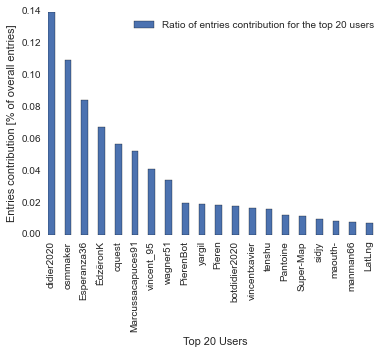

In [44]:
legend = 'Ratio of entries contribution for the top 20 users' 

top_20_entry('created.user', db, legend, True)

plt.ylabel('Entries contribution [% of overall entries]')
plt.xlabel('Top 20 Users')
plt.show()

We can see that more than 50% of the entries have been made by the top 20 contributors. This is typical for the OSM community were a strong contributor core builds the vast majority of the mapping, using existing databases (land registry for instance), and were lots of "small" contributors add some local details related to where they live or work. 

####What are the main amenities registered in the database?

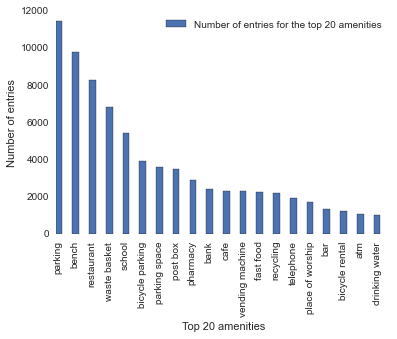

In [43]:
legend = 'Number of entries for the top 20 amenities'

top_20_entry('amenity', db, legend, ratio = False)

plt.ylabel('Number of entries')
plt.xlabel('Top 20 amenities')
plt.show()

Without any surprise, beside the functionnal amenities (parking, benches, waste basket, etc.) the most frequent ones are restaurant and schools. 

####What are the main cities in population around Paris?

In [51]:
pipeline = [
    {'$match': {'population': {'$exists':1}, 'place': {'$exists':1, '$ne':'suburb'}, 'name': {'$exists':1}}},
    {'$sort': {'population':-1}},
    {'$limit':20}
    ]
for doc in db.paris.aggregate(pipeline):
    print doc['name'], doc['place'], doc['population']

Île-de-France state 11852851
Paris city 2243833
Boulogne-Billancourt city 114205
Saint-Denis city 106785
Argenteuil town 102572
Montreuil town 102097
Créteil town 89985
Nanterre town 89185
Courbevoie town 87469
Versailles town 86110
Vitry-sur-Seine town 85413
Colombes town 85398
Aulnay-sous-Bois town 82300
Asnières-sur-Seine town 81666
Rueil-Malmaison town 79426
Aubervilliers town 76087
Champigny-sur-Marne town 75510
Saint-Maur-des-Fossés town 74816
Drancy town 66410
Issy-les-Moulineaux town 64355


####What are the main arrondissements in population in Paris?

In [54]:
pipeline = [
    {'$match': {'population': {'$exists':1}, 'place': 'suburb', 'name': {'$exists':1}}},
    {'$sort': {'population':-1}},
    {'$limit':20}
    ]
for doc in db.paris.aggregate(pipeline):
    print doc['name'], doc['place'], doc['population']

15e Arrondissement suburb 236715
18e Arrondissement suburb 202685
20e Arrondissement suburb 196880
19e Arrondissement suburb 186652
13e Arrondissement suburb 181532
16e Arrondissement suburb 171124
17e Arrondissement suburb 169325
11e Arrondissement suburb 153202
12e Arrondissement suburb 144262
14e Arrondissement suburb 138299
10e Arrondissement suburb 95394
5e Arrondissement suburb 60938
9e Arrondissement suburb 60139
7e Arrondissement suburb 57974
6e Arrondissement suburb 43451
8e Arrondissement suburb 41280
3e Arrondissement suburb 35652
4e Arrondissement suburb 28012
1er Arrondissement suburb 17308


The outer arrondissement are the most populated ones, as they are also the biggest ones and host the low and middle classes. 

For some reasons, the second arrondissement is not registered in the database. This is a correction that could be suggested to the OSM community.

####What are the main cuisine types for the Parisian restaurants?

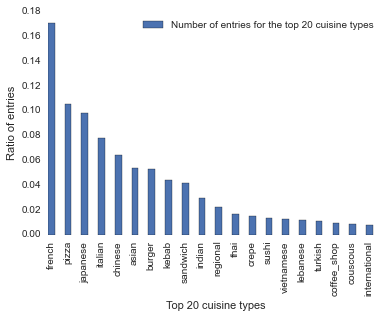

In [72]:
top_20_entry('cuisine', db, ratio = True)

legend = 'Ratio of entries for the top 20 cuisine types' 
plt.legend()
plt.ylabel('Ratio of entries')
plt.xlabel('Top 20 cuisine types')
plt.show()

That is a relief! The main cuisine type in Paris is still French... :) But we can also see that Italian and Asian food are also very frequent. But it is also important to underline that this "analysis" is done on data entered voluntarily. I checked if I could find the restaurants listed in my street, but I could only find a few of them. So I guess there is also some issues about consistency here.

####What are the main traffic calming solutions implemented?

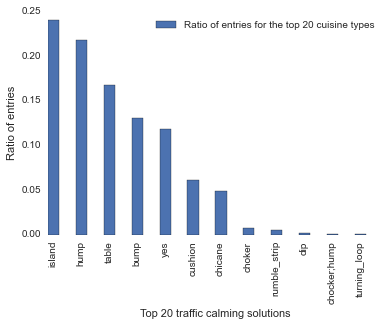

In [74]:
top_20_entry('traffic_calming', db, ratio = True)

legend = 'Ratio of entries for the top 20 traffic calming solutions' 
plt.legend()
plt.ylabel('Ratio of entries')
plt.xlabel('Top 20 traffic calming solutions')
plt.show()

Well, that is always good to know, if you want to shine in society...

####What is the main tree genus registered in the database?

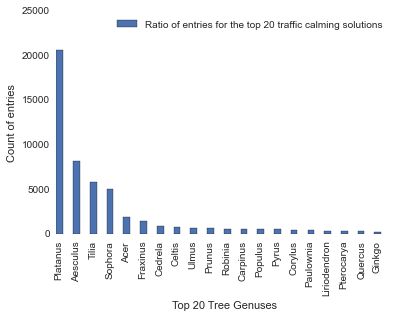

In [78]:
top_20_entry('genus', db, ratio = False)

legend = 'Entries for the top 20 tree genuses' 
plt.legend()
plt.ylabel('Count of entries')
plt.xlabel('Top 20 Tree Genuses')
plt.show()

So there are 20000 registered plane trees in Paris. It is indeed the favorite urban tree. Another fact that will help to shine in society...

##Conclusions

Throughout this work I was able to use OSM data from the Paris Metroline to learn how to assess data quality, clean data if need be, and store it in a MongoDB database.

The first part of my work enabled me to see what the OSM data structure looked like and what were the main data quality issues to be dealt with before importing it in the MongoDB database. It was also the occasion to select the most frequent and useful fields from the entire OSM dataset.

Once the data was stored into MongoDB, it was very easy to access. Pymongo makes the interface between Python and MongoDB very easy. Several funny facts could be discovered from the OSM data:
- who are the main contributors and how much did they contribute to the dataset?
- What are the main amenities?
- What are the main cuisine types?
- What are the biggest cities in population in the dataset?
- What are the main tree genuses?

The second part was focused on parsing the OSM file and restructuring it into a JSON file before importing it to the MongoDB database. Due to the large file size, import in the database had to be done in chunks in order to avoid memory overload.

Once the data stored in the MongoDB database, it was easier to access the entire dataset. The first queries were used to check the data quality of the main entry types, especially for the fields cleaned by the python scripts.

Then, I played a bit with the database to answer some basic questions related to the city of Paris. 

In general, the data quality level was surprisingly high for a human-filled database. The studied entries did not showed major uniformity or validity issues. Accuracy was difficult to assess, as there was no data available to easily compare the database entries. Consistency was also not an issue here, as there was no visible redundancy inside the data.

The main challenge in the dataset is the completeness issue. Most of the entries (street name, postcode, etc.) are not available for each amenity, as they are linked via relation elements (members and node). Though this structure keeps the overall dataset weight fairly low, it complicates our work for now. A next step could be to build an index listing the different elements related to the same postcode and street name. 


## Sources
- OSM Metroline database: https://mapzen.com/data/metro-extracts/
- OSM XML schema: http://wiki.openstreetmap.org/wiki/OSM_XML
- Pprint class that prints unicode: http://stackoverflow.com/questions/10883399/unable-to-encode-decode-pprint-output
- rotate x labels with pyplot: http://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib